## 2. Метрики качества

### 2.1. Loss function

Самой базовой метрикой качества алгоритма является функция ошибки, т.е. функция минимизируемого функционала. Например, в задаче регрессии это может быть **сумма квадратов разностей** ([Mean Squared Error](https://en.wikipedia.org/wiki/Mean_squared_error)), которая представляется формулой:
$$
MSE=\frac{1}{n}\sum_{i=1}^{n}({Y_i-\hat{Y}_i})^2,
$$
где $n$ — количество примеров, $Y_i$ — истинные значения, $\hat{Y_i}$ — предсказанные моделью значения.

В задачах классификации часто применяется ошибка **перекрестная энтропия** ([Cross-entropy](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_error_function_and_logistic_regression)), которая в случае бинарной классификации (**binary cross-entropy**) выглядит следующим образом:
$$
-\frac{1}{n}\sum_{i=1}^{n}{\lbrack(Y_i*log(\hat{Y}_i) + (1-Y_i)*log(1-\hat{Y}_i)\rbrack}
$$

<img src="./img/cross_entropy.png" alt="Binary-cross-entropy" width="100%" align="center">

Для классификации на произвольное количество классов используется функция ошибки в общем виде:
$$
-\frac{1}{n}\sum_{i=1}^{n}{\sum_{c=1}^{C}{Y_i^c*log(\hat{Y}_i^c)}},
$$
где $C$ — количество классов в задаче.

Посчитаем значение ошибки для случайно предсказанных классов. Нашим алгоритмом будет монетка с тремя гранями, которая пытается угадать класс ириса.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
from sklearn.datasets import load_iris

iris_source = load_iris()

target_names = iris_source['target_names']

iris_data_path = iris_source['filename']

iris_data = pd.read_csv(iris_data_path,
                        names=['sepal_length', 'sepal_width',
                               'petal_length', 'petal_width', 'class'], header=0)

In [3]:
target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [4]:
iris_data['class'] = iris_data['class'].apply(lambda x: target_names[x])

In [5]:
# Функция, выбирающая один класс из заданного кол-ва классов
def monetka(n_classes=3):
    classes = np.arange(n_classes)
    predicted = np.random.choice(classes)
    
    return predicted

In [6]:
# Определить количество примеров, классов и сформировать словарь для конвертирования имени класса в порядковое число
n = iris_data.shape[0]
class_to_num = {cl: num for num, cl in enumerate(np.unique(iris_data['class']))}
n_classes = len(class_to_num)

In [7]:
# Истинные значения
y = np.array(iris_data['class'].apply(lambda cl: class_to_num[cl]))

In [8]:
# Предсказанные монеткой значения
y_pred = np.array([monetka(n_classes) for _ in range(n)])
y_hat = np.zeros((n, n_classes), dtype=np.float32)
for num in class_to_num.values():
    y_hat[:, num] = 1. * (y_pred == num)

In [9]:
from sklearn.metrics import log_loss

In [10]:
# Посчитаем значение ошибки
log_loss(y, y_hat)

22.335075403849284

Одно значение ошибки мало о чем говорит. Функции ошибки не всегда читаются напрямую, а имеют смысл при просмотре в сравнении: при хорошей сходимости алгоритма ошибка должна существенно падать после очередной итерации обучения:

![validation loss example](./img/valid_loss_example.png)

Для более понятных человеку результатов рассмотрим класс популярных метрик, относящихся к бинарной классификации.

Для подсчета метрик возьмем искусственную задачу, где определим истинные классы следующим образом:

In [11]:
n = 100    # размер выборки
p = 0.1    # доля примеров класса 1

In [12]:
from scipy import stats

In [13]:
# Сгенерируем n примеров с долей единиц равной p
dist = stats.bernoulli(p)
y_true = dist.rvs(n)
print(y_true)

[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]


### 2.2. Accuracy

**Accuracy** (точность) — самая базовая метрика для определения точности алгоритма, которая подсчитывает количество правильно предсказанных объектов к общему числу объектов.

#### Введем следующие понятия для формального определения метрик:  
**True positives (TP)** — кол-во правильно предсказанных примеров положительного класса  
**True negatives (TN)** — кол-во правильно предсказанных примеров отрицательного класса  
**False positives (FP)** — кол-во неправильно предсказанных примеров положительного класса (ложных срабатываний)  
**False negatives (FN)** — кол-во неправильно предсказанных примеров отрицательного класса (ложных отрицаний)  
__Positives (P)__ - общее кол-во примеров положительного класса  
**Negatives (N)** - общее кол-во примеров отрицательного класса

![Error table](./img/errors_table.png)

Тогда формально метрика accuracy выразится следующим образом:
$$
accuracy = \frac{TP+TN}{Positive+Negative}
$$

In [14]:
def calc_accuracy(y_true, y_pred):
    P = np.sum(y_true == 1)
    N = np.sum(y_true == 0)
    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))

    acc = (TP + TN) / (P + N)
    
    return acc, TP, TN, P, N

Возьмем предсказания двугранной монетки для нашей выборки:

In [15]:
y_pred = np.array([monetka(2) for _ in range(n)])

Посчитаем значение accuracy:

In [16]:
acc, TP, TN, P, N = calc_accuracy(y_true, y_pred)
print('TP = {}\nTN = {}\nP = {}\nN = {}\nacc = {}%'.format(TP, TN, P, N, acc * 100))

TP = 3
TN = 49
P = 7
N = 93
acc = 52.0%


То же самое можно сделать с помощью функции [accuracy_score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) библиотеки scikit-learn:

In [17]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_true, y_pred)
print('Accuracy from scikit-learn: {}%'.format(acc * 100))

Accuracy from scikit-learn: 52.0%


Наш алгоритм работает с точностью 50% (может отличаться от запуска к запуску). Совсем неплохо для случайной монетки. Но давайте попробуем улучшить результат. Мы же знаем, что наша выборка приблизительно на 90% состоит из примеров отрицательного класса. Тогда пусть наша монетка будет однобокой и всегда будет выдавать 0 в качестве ответа:

In [18]:
y_pred = np.zeros(n)

In [19]:
acc, TP, TN, P, N = calc_accuracy(y_true, y_pred)
print('TP = {}\nTN = {}\nP = {}\nN = {}\nacc = {}%'.format(TP, TN, P, N, acc * 100))

TP = 0
TN = 93
P = 7
N = 93
acc = 93.0%


90%! Монетка стала предсказывать еще лучше.  
На самом деле монетка предсказывает только один класс, абсолютно игнорируя второй. В этом и есть главная проблема метрики accuracy: если выборка содержит разное количество примеров каждого класса, то добиться высокой точности можно даже просто не предсказывая редкие классы.  
Для таких несбалансированных выборок accuracy не может являться ключевой метрикой. Далее мы рассмотрим метрики, с помощью которых можно избежать дизбаланса классов, такие как precision, recall и F1-score.

### 2.3. precision и recall

**precision** — метрика, измеряющая, насколько много из принятых моделью положительных объектов в действительности являются положительными.  
**recall** — метрика, измеряющая, насколько много положительных объектов из всех положительных объектов модель выбрала.

$$
precision = \frac{TP}{TP+FP} \quad recall = \frac{TP}{TP+FN}
$$

Интересный факт про обе метрики заключается в том, что при возрастании одной общей тенденцией второй является падение. В некотором смысле они противоположны. Это отражает следующий пример графика:
<img src="./img/precision-recall-curve.png" alt="precision-recall-curve" width="400" align="center">  

Посчитаем метрики precision и recall для нашей задачи с помощью методов [precision_score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html) и [recall_score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html) библиотеки scikit-learn:

In [20]:
from sklearn.metrics import precision_score, recall_score

In [21]:
precision = precision_score(y_true, 1 - y_pred)
recall = recall_score(y_true, 1 - y_pred)
print('precision: {:.2f}\nrecall: {:.2f}'.format(precision, recall))

precision: 0.07
recall: 1.00


Полученные значения метрик говорят, что алгоритм никогда не назначает объектам положительный класс. Тут мы его и поймали. А теперь подумайте, что бы случилось, если положительным классом было наличие раковой болезни человека — модель бы не нашла рак ни у одного пациента!

Вернемся к случаю, где модель выбирает положительный и отрицательный классы с равной вероятностью:

In [22]:
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print('precision: {:.2f}\nrecall: {:.2f}'.format(precision, recall))

precision: 0.00
recall: 0.00


C:\Users\Eldar_Kalachev\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision в данном случае говорит, что из тех объектов, которые модель считает положительными, в действительности очень мало положительных. recall говорит, что модель хотя бы какой-то относительно неплохой процент положительных объектов все-таки находит. По двум числам трудно оценивать модель, поэтому были придуманы объединяющие метрики, такие как F1-score.

### 2.4. F1-score

**F1-score** — метрика, объединяющая precision и recall, принимающая во внимание, что и та, и другая важны для задачи.

$$
F1\_score = \frac{2*precision*recall}{precision+recall}
$$

Вообще говоря, метрика F1-score является частным случаем метрики F-beta score, о которой вы можете прочитать [здесь](https://en.wikipedia.org/wiki/F1_score#Definition).

Посчитаем F1-score для нашей задачи с помощью метода [f1_score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) библиотеки scikit-learn:

In [23]:
from sklearn.metrics import f1_score

In [24]:
f1 = f1_score(y_true, y_pred)
print('F1-score: {:.2f}'.format(f1))

F1-score: 0.00


Чем выше значение F1-score, тем лучше. Как видим, наш алгоритм работает неудовлетворительно.  
И это неудивительно, что неудовлетворительно.

### 2.5. precision-recall curve

**precision-recall curve** показывает зависимость precision от recall, т.е. насколько точно алгоритм выбирает положительные объекты при изменении его чувствительности к положительному классу.

Посчитаем precision-recall curve, используя метод [precision_recall_curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html) библиотеки scikit-learn:

In [25]:
from sklearn.metrics import precision_recall_curve

In [26]:
precisions, recalls, _ = precision_recall_curve(y_true, y_pred)

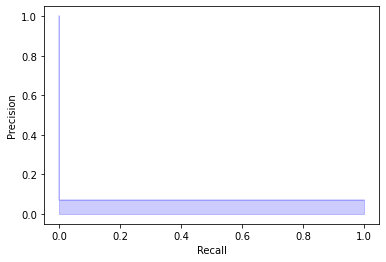

In [27]:
plt.step(recalls, precisions, color='b', alpha=0.2, where='post')
plt.fill_between(recalls, precisions, step='post', alpha=0.2, color='b')
plt.xlabel('Recall');
plt.ylabel('Precision');

Еще одной обобщающей характеристикой precision и recall является **average precision (AP)**, которая вычисляется как взвешенное среднее значений precision:
$$
AP = \sum_{n}{(R_n - R_{n-1})P_n},
$$
где $P_n$ и $R_n$ — precision и recall при $n$-ом отсечении. В некотором приближении значение AP есть значение иной характеристики, называемой **area under curve (AUC)** (площадь под кривой), являющейся важной метрикой при разработке классификаторов и детекторов.

Вычислим AP, используя метод [average_precision_score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html) библиотеки scikit-learn:

In [28]:
from sklearn.metrics import average_precision_score

In [29]:
ap = average_precision_score(y_true, y_pred)
print('Average Precision (AP) = {:.2f}'.format(ap))

Average Precision (AP) = 0.07


### 2.6. Confusion matrix

[confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) — матрица, в строках которой отображено число примеров, предсказанных в определенном классе, а в столбцах число примеров, которые в самом деле принадлежат каждому классу (и наоборот). С помощью confusion matrix можно удобно смотреть, в какую сторону отклоняются предсказания алгоритма при виде объектов определенного класса.

![confusion matrix](./img/confusion_matrix2.png)

Вернемся к задаче с ирисами и посчитаем confusion matrix с помощью метода [confusion_matrix](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) библиотеки scikit-learn:

In [30]:
from sklearn.metrics import confusion_matrix

In [31]:
# Определить количество примеров, классов и сформировать словарь для конвертирования имени класса в порядковое число
n = iris_data.shape[0]
class_to_num = {cl: num for num, cl in enumerate(np.unique(iris_data['class']))}
n_classes = len(class_to_num)

# Истинные значения
y_true = np.array(iris_data['class'].apply(lambda cl: class_to_num[cl]))

# Предсказанные монеткой значения
y_pred = np.array([monetka(n_classes) for _ in range(n)])

In [32]:
conf_mat = confusion_matrix(y_true, y_pred).T
print('Confusion matrix:\n{}'.format(conf_mat))

Confusion matrix:
[[17 17 20]
 [14 19 17]
 [19 14 13]]


Нарисуем confusion matrix так, чтобы было понятнее, что происходит:

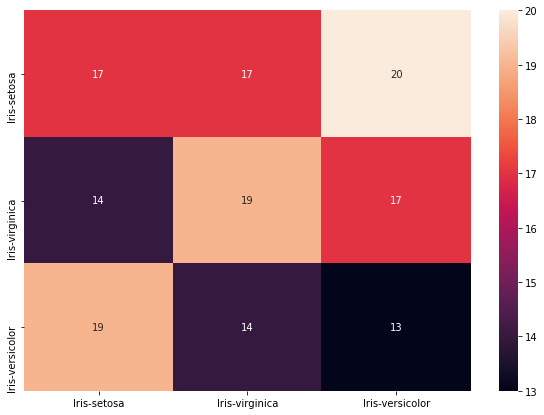

In [33]:
import seaborn as sn
class_names = ['Iris-setosa', 'Iris-virginica', 'Iris-versicolor']
df_cm = pd.DataFrame(conf_mat, index=class_names, columns=class_names)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True);

### Задание

> Загрузите данные train.csv, оставьте в данных только признаки 'fine_amount', 'state_fee', 'late_fee', 'discount_amount', 'balance_due', затем избавьтесь от пропусков. Целевой переменной будет 'balance_due', разделите данные на обучающую и тестовую выборки в соотношении 70% на 30% без перемешивания. Обучите линейную регрессию из scikit-learn и выведите значение метрики RMSE на тестовой выборке.

In [34]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [35]:
vis_data = pd.read_csv(
    "./data/train.csv", encoding='ISO-8859-1', low_memory=False)

vis_data.sample(3)

,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,...,clean_up_cost,judgment_amount,payment_amount,balance_due,payment_date,payment_status,collection_status,grafitti_status,compliance_detail,compliance
9616,27632,Detroit Police Department,"Crawford, Kenneth","smith, joe l",19379.0,LAUDER,NaN,19379.0,lauder,detroit,...,0.0,2780.0,0.0,2780.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0
213629,246697,Detroit Police Department,"Holbrook, Kevin","nereim, robert allan",4445.0,TOLEDO,NaN,4445.0,toledo,detroit,...,0.0,0.0,0.0,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN
88884,114039,"Buildings, Safety Engineering & Env Department","Gailes, Orbie J","MCCALL, CURTIS",16635.0,LOG CABIN,NaN,16635.0,LOG CABIN,DETROIT,...,0.0,0.0,0.0,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN


In [36]:
vis_data_clear = vis_data[['fine_amount', 'state_fee', 'late_fee', 'discount_amount', 'balance_due']].dropna()

In [37]:
X, y = vis_data_clear[['fine_amount', 'state_fee', 'late_fee', 'discount_amount']], vis_data_clear[['balance_due']]

In [38]:
X_train, X_test, y_train,y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    shuffle=False
)

In [39]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [40]:
RMSE = np.sqrt(
    mean_squared_error(
        y_test,
        model.predict(X_test)
    )
)

print(RMSE)

132.080334458986
